# Dataset download from Google Drive

In [1]:
import zipfile
from google.colab import drive

#drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/datasetXL.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

# Imports

In [2]:
import sys, time
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import tensorflow as tf
from keras.preprocessing.image import img_to_array, save_img, ImageDataGenerator
import cv2
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import keras
import numpy as np
from tensorflow.keras.utils import to_categorical
import gc
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
import os
import imutils


# Load images on df: path - label 

In [39]:
data_dir = Path("datasetXL/")
train_dir = data_dir/'train'
test_dir = data_dir/'val'

def load_data(directories):  

  dfs = {}
  for dir in directories:

    path_and_label = {}
    normal_dir = dir/'Normal'
    pneumonia_dir = dir/'Pneumonia'
    covid_dir = dir/'Covid' 

    normal_paths = normal_dir.glob('*.jpeg')
    pneumonia_paths = pneumonia_dir.glob('*.jpeg')
    covid_paths = covid_dir.glob('*.jpeg') 

    for path in normal_paths:
      path_and_label[path] = 'Normal'
    for path in pneumonia_paths:
      path_and_label[path] = 'Pneumonia'
    for path in covid_paths:
      path_and_label[path] = 'Covid'

    path_and_label_df = pd.DataFrame(path_and_label.items())
    path_and_label_df = path_and_label_df.rename(columns = { 0: 'path', 1: 'label'})

    #* shuffle dataset and reset index
    path_and_label_df = path_and_label_df.sample(frac = 1).reset_index(drop = True)

    dfs[dir] = path_and_label_df

  return dfs

dirs = [ train_dir, test_dir]
data_dfs = load_data(dirs)

train_df = data_dfs[train_dir]
test_df = data_dfs[test_dir]

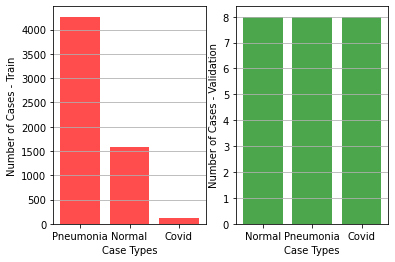

In [40]:
plt.subplot(1, 2, 1)
plt.bar(train_df['label'].value_counts().index,train_df['label'].value_counts().values, color = 'r', alpha = 0.7)
plt.xlabel("Case Types")
plt.ylabel("Number of Cases - Train")
plt.grid(axis='y')

plt.subplot(1, 2, 2)
plt.bar(val_df['label'].value_counts().index,val_df['label'].value_counts().values, color = 'g', alpha = 0.7)

plt.xlabel("Case Types")
plt.ylabel("Number of Cases - Validation")
plt.grid(axis='y')

# Downsampling

In [41]:
num_covid = len(train_df[train_df['label'] == 'Covid'])
num_norm = len(train_df[train_df['label'] == 'Normal'])
num_pneu = len(train_df[train_df['label'] == 'Pneumonia'])

np.random.seed(10)
drop_indices_norm = np.random.choice(train_df[train_df['label'] == 'Normal'].index, (num_norm - (num_covid * 4)), replace=False)
drop_indices_pneu = np.random.choice(train_df[train_df['label'] == 'Pneumonia'].index, (num_pneu - (num_covid * 4)), replace=False)
drop_indices = np.concatenate((drop_indices_norm, drop_indices_pneu))

train_df_downsampled = train_df.drop(drop_indices)


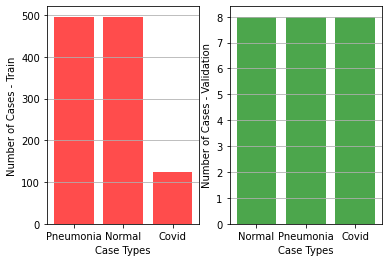

In [42]:
plt.subplot(1, 2, 1)
plt.bar(train_df_downsampled['label'].value_counts().index,train_df_downsampled['label'].value_counts().values, color = 'r', alpha = 0.7)
plt.xlabel("Case Types")
plt.ylabel("Number of Cases - Train")
plt.grid(axis='y')

plt.subplot(1, 2, 2)
plt.bar(val_df['label'].value_counts().index,val_df['label'].value_counts().values, color = 'g', alpha = 0.7)

plt.xlabel("Case Types")
plt.ylabel("Number of Cases - Validation")
plt.grid(axis='y')

In [43]:
df_train = train_df_downsampled.sample(frac=0.8, random_state=1)
df_val = train_df_downsampled.drop(df_train.index)

# Prepare

In [44]:
def prepare(df):
  data, labels = [], []

  for j, row in df.iterrows():

    img = cv2.imread(str(row['path']))  #* read image from path
    img = cv2.resize(img, (224,224))     #* 224x224
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img_.astype(np.float32)/255.

    sys.stdout.write('\r{0}'.format(str(j)))
    

    data.append(img)

    label_str = row['label']

    if label_str == 'Covid':
      labels.append(to_categorical(0, num_classes = 3))
    elif label_str == 'Normal': 
      labels.append(to_categorical(1, num_classes = 3))
    else:
      labels.append(to_categorical(2, num_classes = 3))

    sys.stdout.flush()

  return np.asarray(data), np.asarray(labels)

In [ ]:
train_data, train_label = prepare(df_train)
val_data, val_label = prepare(df_val)
test_data, test_label = prepare(test_df)

# Generate flipped

In [11]:
def generate_flipped(dir, label):

    input_img_list = dir.glob('*.jpeg')
    data = []
    lbl = []
    for img in input_img_list:
        sys.stdout.write('\r{0}'.format(str(img)))
        img_f = cv2.imread(str(img)) 
        img_f = cv2.resize(img_f, (224,224))
        img_ = cv2.cvtColor(img_f, cv2.COLOR_BGR2RGB)
        img_f = img_.astype(np.float32)/255. 
        flipped = tf.image.flip_left_right(img_f)
        data.append(flipped)
        
        if label == 'Covid':
            lbl.append(to_categorical(0, num_classes = 3))
        elif label == 'Normal': 
            lbl.append(to_categorical(1, num_classes = 3))
        else:
            lbl.append(to_categorical(2, num_classes = 3))

        sys.stdout.flush()

    data = np.array(data)
    lbl = np.array(lbl)
    
    return data, lbl

In [ ]:
#* Generate flipped only on covid cases to reduce imbalance problem
flipped_data, flipped_label = generate_flipped(train_dir/'Covid', 'Covid')

In [ ]:
train_data_f = np.vstack([train_data, flipped_data])
train_label_f = np.vstack([train_label, flipped_label])

del train_data
del train_label
gc.collect()

# Generate Rotated

In [14]:
def generate_rotated_img(dir, label, angle, cropped = False, opposite_angle = False): 

    input_img_list = dir.glob('*.jpeg')
    data = []
    lbl = []

    def write_label(label):
        if label == 'Covid':
            lbl.append(to_categorical(0, num_classes = 3))
        elif label == 'Normal': 
            lbl.append(to_categorical(1, num_classes = 3))
        else:
            lbl.append(to_categorical(2, num_classes = 3))

    def rotate(img, angle, cropped):
        if cropped:
            rotated = imutils.rotate(img, angle)
            rotated = cv2.resize(rotated, (224,224))
            data.append(rotated)
            write_label(label)
        else:
            rotated = imutils.rotate_bound(img, angle)
            rotated = cv2.resize(rotated, (224,224))
            data.append(rotated)
            write_label(label)


    for img in input_img_list:
        sys.stdout.write('\r{0}'.format(str(img)))
        img_r = cv2.imread(str(img)) 
        img_r = cv2.resize(img_r, (224,224))
        img_ = cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB)
        img_r = img_.astype(np.float32)/255. 

        if opposite_angle:
            rotate(img_r, angle, cropped) 
            rotate(img_r, angle*-1, cropped)              
        else:
            rotate(img_r, angle, cropped) 
        
        sys.stdout.flush()

    data = np.array(data)
    lbl = np.array(lbl)
    
    return data, lbl


In [ ]:
rotated_data5, rotated_label5 = generate_rotated_img(train_dir/'Covid', 'Covid', 5)

train_data_r5 = np.vstack([train_data_f, rotated_data5])
train_label_r5 = np.vstack([train_label_f, rotated_label5])

del train_data_f
del train_label_f
gc.collect()

In [ ]:
rotated_data10, rotated_label10 = generate_rotated_img(train_dir/'Covid', 'Covid', 10)

train_data_r10 = np.vstack([train_data_r5, rotated_data10])
train_label_r10 = np.vstack([train_label_r5, rotated_label10])

del train_data_r5
del train_label_r5
gc.collect()

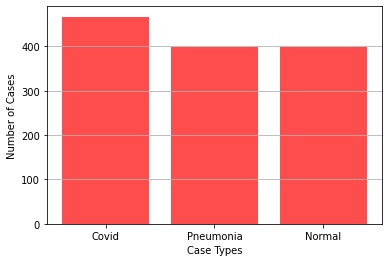

In [20]:
categories = np.argmax(train_label_r10, axis=1)
cat_labels = []

for label in categories:
    if label == 0:
        cat_labels.append('Covid')
    elif label == 1:
        cat_labels.append('Normal')
    else:
        cat_labels.append('Pneumonia')

label_df = pd.DataFrame(cat_labels)
plt.bar(label_df[0].value_counts().index, label_df[0].value_counts().values, color = 'r', alpha = 0.7)
plt.xlabel("Case Types")
plt.ylabel("Number of Cases")
plt.grid(axis='y')

In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=64,activation="relu"))
model.add(Dense(units=3, activation="softmax"))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_path = "content/cnn_covid.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

hist = model.fit(train_data_r10, train_label_r10, 
                  validation_data= (val_data, val_label), 
                 epochs=5, callbacks=[checkpoint])


# Prediction

In [ ]:
cnn_model = load_model("content/cnn_covid.h5")

tp = 0
for i in range(0, len(test_data)):
    img = test_data[i].reshape(1, 224, 224, 3)
    pred = cnn_model.predict(img)


    index = np.where(pred == np.amax(pred))
    index_ = np.where(test_label[i] == np.amax(test_label[i]))

    if index[1] == index_[0]:
        tp += 1

tp


In [ ]:
ratio = (100 * tp)/len(test_data)
ratio